# Car price prediction

### Project description

Used car sales service is developing app to attract new customers. In this app one can quickly find out market price of cars. Service want model to be built to predict cost of cars.

Service is interested in:

- quality of prediction;
- speed of prediction;
- time required for training

Key metric **RMSE** should have value under **2500**

### Work plan

- Load data
- Data preprocessing
- Models learning. One of model should be **LGBMRegressor**
- Learning and prediction time analysis, model quality check
- Conclusion

## Load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import warnings                   
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

STATE = np.random.RandomState(3101)

data = pd.read_csv('/datasets/autos.csv')

## Data preprocessing

In [2]:
data.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
4091,2016-03-08 08:54:11,1800,NaN,2017,manual,115,cooper,150000,1,NaN,mini,NaN,2016-03-08 00:00:00,0,66450,2016-03-08 08:54:11
226609,2016-04-03 11:58:35,4500,bus,2004,manual,116,touran,150000,4,petrol,volkswagen,no,2016-04-03 00:00:00,0,85599,2016-04-07 13:16:58
135200,2016-03-22 22:36:18,100,sedan,1994,manual,0,NaN,5000,0,petrol,opel,NaN,2016-03-22 00:00:00,0,3130,2016-03-25 22:47:00
96412,2016-04-05 11:50:00,6500,sedan,2001,manual,179,a4,150000,11,gasoline,audi,no,2016-04-05 00:00:00,0,53498,2016-04-05 11:50:00
192618,2016-03-12 19:52:11,12500,wagon,2009,manual,177,5er,150000,1,gasoline,bmw,yes,2016-03-12 00:00:00,0,87435,2016-04-05 12:21:09


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


#### interim output
- There are missing values in 5 features
- `Price`, `RegistrationYear`, `Power` features have abnormal values
- `NumberOfPictures` feature contains only zeros. Absolutely useless
- `RegistrationMonth` feature contains zero month. Seems to be data-filling error

Check duplicates

In [6]:
data.duplicated().sum()

4

Drop them

In [7]:
data = data.drop_duplicates()

Check abnormal values

In [8]:
def plot(column, l, m, ylabel, bins):
    plt.figure(figsize=(6,6), dpi = 90)
    sns.set_style("darkgrid")
    sns.boxplot(data=column, palette = 'pastel')
    plt.ylim([l, m])
    plt.ylabel(ylabel)
    plt.show()
    
    column.hist(bins=bins, 
                figsize=(10,6)).set_xlim((l,m))
    plt.xlabel(ylabel)
    plt.ylabel('Quantity')

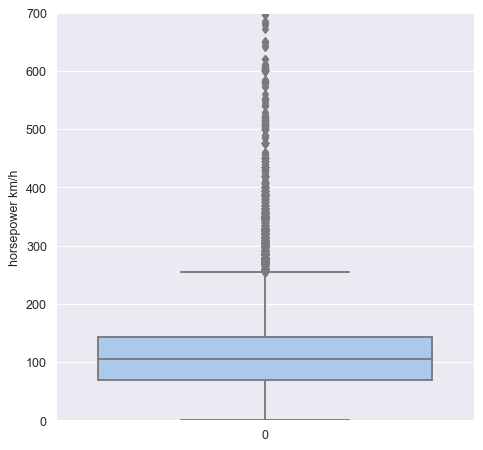

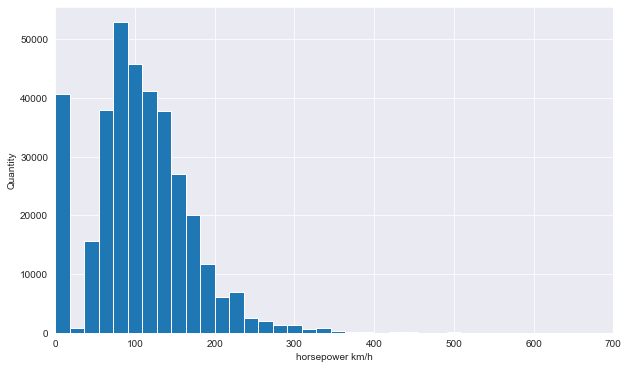

In [9]:
plot(data['Power'], 0, 700, 'horsepower km/h', 1100)

As boxplot shows in `Power` feature outliers start from about **255**. Looking at distribution there is large number of values gathered near **0**. But in my memory cars with power **500-600** hp are not rare, so we will remove emissions from **630** hp. Cars with **0**hp are unlikely to go anywhere. So we will delete **0** values too

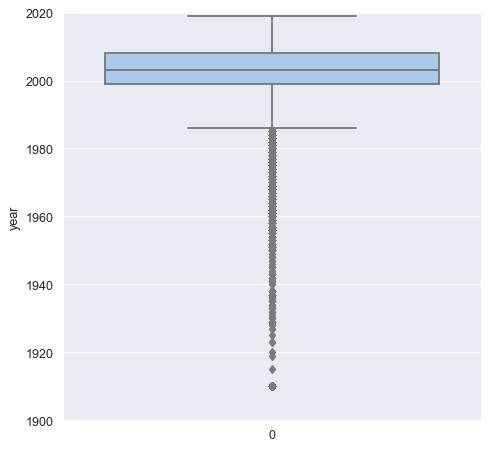

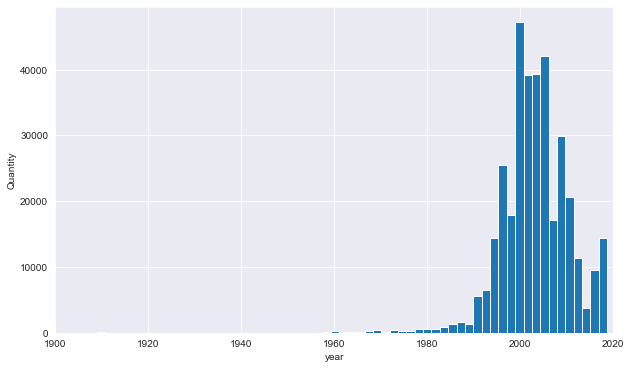

In [10]:
plot(data['RegistrationYear'], 1900, 2020, 'year', 5000)

In this case, we see that on boxplot there are abnormal values up to **1985**. Distribution shows some spike around **2019-2020**. But according to terms of project, we are in **2016**. So we can't sell cars produced later than **2016**. On distribution chart there is a small number of values near **1960**. Such oldtimers are often sold quite expensive. Let's limit bottom year to **1960** and top year to **2016**.

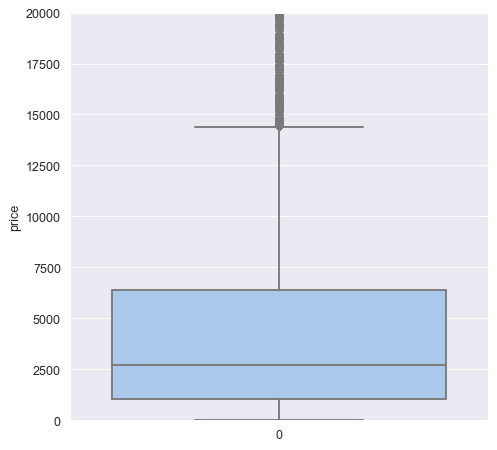

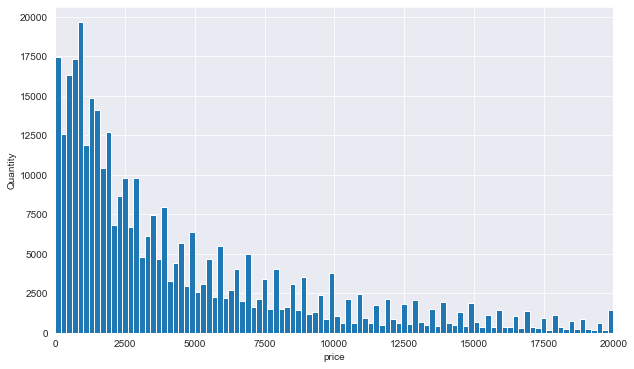

In [11]:
plot(data['Price'], 0, 20000, 'price', 100)

As boxplot shows in `Price` feature outliers start from about **14700**. Probably oldtimers or powerful luxury cars. Leave them. Distribution chart shows large number of values near **0**. We will get rid of these values. The essence of business is to sell, not to present.

Clean data

In [12]:
data = data.loc[(data['Power'] >= 25) 
                & (data['Power'] <= 630)
                & (data['RegistrationYear'] >= 1960) 
                & (data['RegistrationYear'] <= 2016)
                & (data['Price'] != 0)]

Check `DateCreated` feature for usefulness. Usually cars with longer period of selling have lower price.

In [13]:
data['DateCreated']

1         2016-03-24 00:00:00
2         2016-03-14 00:00:00
3         2016-03-17 00:00:00
4         2016-03-31 00:00:00
5         2016-04-04 00:00:00
                 ...         
354361    2016-03-09 00:00:00
354362    2016-03-19 00:00:00
354366    2016-03-05 00:00:00
354367    2016-03-19 00:00:00
354368    2016-03-20 00:00:00
Name: DateCreated, Length: 295976, dtype: object

Feature is useless. Could be dropped

In [14]:
data = data.drop(['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated'], axis=1)

Let's check duplicates once more

In [15]:
data.duplicated().sum()

23131

Too much

In [16]:
data.loc[data.duplicated()].sort_values(by=['Model', 'Power'], ascending=False).head(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
117536,7999,bus,2006,manual,241,zafira,150000,4,petrol,opel,no
120151,8555,bus,2006,manual,241,zafira,150000,9,petrol,opel,no
182650,3500,bus,2004,manual,200,zafira,150000,2,petrol,opel,no
246279,6250,bus,2005,manual,200,zafira,125000,6,petrol,opel,no
154271,2100,wagon,2002,manual,192,zafira,125000,5,petrol,opel,no
202753,2100,wagon,2002,manual,192,zafira,125000,5,petrol,opel,no
225546,3880,bus,2002,manual,192,zafira,150000,2,petrol,opel,no
26731,8800,wagon,2011,manual,165,zafira,30000,12,gasoline,opel,no
61014,8800,wagon,2011,manual,165,zafira,30000,12,gasoline,opel,no
67376,8800,wagon,2011,manual,165,zafira,30000,12,gasoline,opel,no


Drop them

In [17]:
data = data.drop_duplicates()

Missing values

In [18]:
data.isna().sum()

Price                    0
VehicleType          10680
RegistrationYear         0
Gearbox               5173
Power                    0
Model                10524
Kilometer                0
RegistrationMonth        0
FuelType             15140
Brand                    0
Repaired             40599
dtype: int64

In [19]:
data['VehicleType'].value_counts()

sedan          76063
small          64137
wagon          54264
bus            24372
convertible    17361
coupe          13652
suv             9988
other           2328
Name: VehicleType, dtype: int64

In [20]:
data['Gearbox'].value_counts()

manual    213717
auto       53955
Name: Gearbox, dtype: int64

In [21]:
data['Model'].value_counts()

golf                  22472
other                 19248
3er                   15890
polo                   9748
corsa                  9128
                      ...  
serie_2                   5
kalina                    4
serie_3                   3
rangerover                2
range_rover_evoque        1
Name: Model, Length: 249, dtype: int64

In [22]:
data['FuelType'].value_counts()

petrol      172642
gasoline     79964
lpg           4338
cng            448
hybrid         197
other           78
electric        38
Name: FuelType, dtype: int64

In [23]:
data['Repaired'].value_counts()

no     204734
yes     27512
Name: Repaired, dtype: int64

In [24]:
data.loc[(data['Model'] == 'golf') & data['VehicleType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
35,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no
77,800,NaN,2000,manual,90,golf,150000,2,gasoline,volkswagen,NaN
233,3750,NaN,2005,NaN,75,golf,150000,0,NaN,volkswagen,NaN
408,1,NaN,2000,NaN,75,golf,90000,3,petrol,volkswagen,NaN
541,4550,NaN,2016,manual,101,golf,150000,8,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...,...
353015,30,NaN,2016,manual,75,golf,150000,10,petrol,volkswagen,yes
353103,499,NaN,1995,auto,69,golf,150000,0,petrol,volkswagen,NaN
353474,3999,NaN,2007,manual,75,golf,100000,5,petrol,volkswagen,no
354068,3700,NaN,2016,manual,90,golf,150000,4,gasoline,volkswagen,NaN


#### interim output
- All features with missing values are categorical
- In `VehicleType` feature we fill missing values with **unknown**
- In `Gearbox` feature we fill missing values with **other**
- Missing values in `Model`, `Repaired` features we fill with **unknown**
- `FuelType` feature contains two values with same meaning **gasoline** и **petrol**. We use **petrol** for both of them. Missimg values we fill with **diesel**. Seems to be good idea, but to be honest we can fill with **unknown** or **other**, doesn't matter

In [25]:
data['Gearbox'] = data['Gearbox'].fillna('other')

data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Model'] = data['Model'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('diesel')
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')
data['Repaired'] = data['Repaired'].fillna('unknown')

data.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
346501,150,other,1994,manual,60,combo,150000,4,petrol,opel,no
42491,1250,sedan,1998,manual,125,a4,150000,11,petrol,audi,no
296106,4500,small,2005,manual,75,golf,150000,3,petrol,volkswagen,no
50487,7000,sedan,1990,manual,129,3er,150000,10,petrol,bmw,no
133438,250,sedan,1989,manual,70,80,150000,9,petrol,audi,no


In [26]:
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

Data is ok

## Models learning

Encode categorical features

In [27]:
enc = OrdinalEncoder()
enc.fit(data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']])
(data[['VehicleType', 
       'Gearbox', 
       'Model', 
       'FuelType', 
       'Brand', 
       'Repaired']]) = enc.transform(
                                        data[['VehicleType', 
                                              'Gearbox', 
                                              'Model', 
                                              'FuelType', 
                                              'Brand', 
                                              'Repaired']])

Train test split

In [28]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop('Price', axis=1), data.Price, test_size=0.25, random_state=STATE)

print(f'Train sample share: {features_train.shape[0] / len(data):.1%}')
print(f'Test sample share: {features_test.shape[0] / len(data):.1%}')

Train sample share: 75.0%
Test sample share: 25.0%


Scale features

In [29]:
numeric = ['VehicleType', 'RegistrationYear', 
           'Gearbox', 'Power', 'Model', 'Kilometer', 
           'RegistrationMonth', 'FuelType', 'Brand', 
                                       'Repaired']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Write functions for learning and predicting

In [30]:
def rmse(target, predicted):
    return mean_squared_error(target, predicted) ** 0.5

In [31]:
rmse_score = make_scorer(rmse, greater_is_better=False)

In [32]:
def models(model, parametrs, features_train, target_train, features_test, target_test):
    grid = GridSearchCV(model, parametrs, cv=5, n_jobs=-1, scoring=rmse_score)
    initial_time = time.time()
    grid.fit(features_train, target_train)
    fit_time = time.time() - initial_time
    initial_time = time.time()
    predict = grid.predict(features_test)
    predict_time = time.time() - initial_time
    return round(fit_time, 2), round(predict_time, 2), round(rmse(target_test, predict))

In [33]:
def models_2(model, features_train, target_train, features_test, target_test):
    initial_time = time.time()
    model.fit(features_train, target_train)
    fit_time = time.time() - initial_time
    initial_time = time.time()
    predict = model.predict(features_test)
    predict_time = time.time() - initial_time
    return round(fit_time, 2), round(predict_time, 2), round(rmse(target_test, predict))

## Models analysis

LightGBM

In [34]:
lgbm_parametrs = {'n_estimators': [50,100], 
                  'max_depth': [5,10], 
                  'num_leaves': [10,20], 
                  'learning_rate': [0.1]}
lgbm_model = LGBMRegressor(random_state=STATE)
lgbm = models(lgbm_model, 
              lgbm_parametrs, 
              features_train, target_train, features_test, target_test)
lgbm

(158.18, 0.62, 1726)

Decision Tree

In [35]:
dtr_parametrs = {'max_depth' : range (1,10)}
dtr_model = DecisionTreeRegressor(random_state=STATE)
dtr = models(dtr_model, 
             dtr_parametrs, 
             features_train, target_train, features_test, target_test)
dtr

(61.05, 0.04, 2024)

Linear Regression

In [36]:
lr_model = LinearRegression()
lr = models_2(lr_model, 
              features_train, target_train, features_test, target_test)
lr

(0.59, 0.01, 3006)

Constant model

In [37]:
dummy_r_model = DummyRegressor(strategy='mean')
dummy_r = models_2(dummy_r_model, 
              features_train, target_train, features_test, target_test)
dummy_r

(0.0, 0.0, 4612)

In [38]:
result = pd.DataFrame([lgbm, 
                       dtr, 
                       lr, 
                       dummy_r], 
                       columns=['Learning time', 
                                'Prediction time', 
                                'RMSE'], 
                       index=['LGBMRegressor',
                              'DecisionTreeRegressor',
                              'LinearRegression', 
                              'DummyRegressor'])

In [39]:
result

,Learning time,Prediction time,RMSE
LGBMRegressor,158.18,0.62,1726
DecisionTreeRegressor,61.05,0.04,2024
LinearRegression,0.59,0.01,3006
DummyRegressor,0.00,0.00,4612


## Conclusion
- `LGBMRegressor` has best quality, `RMSE` is equal to **1726**. Learning time is **158** seconds, prediction time is **0,6** seconds
- `Constant model` has `RMSE` equal to **4612**
- Validity check is done